# Modeling data to predict precipitation value in WIZNA

The aim of this notebook is to use ARIMA model in order to predict precipitation value. The main taks consists on establishing right values of parameters used in ARIMA model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error


In [2]:
# importing the data from one single CSV file, prepared in notebook 02.
data = pd.read_csv('Data/Merged_Data/precipitat_data_WIZNA_1951_2019.csv')

In [3]:
data


,station_ID,station_name,year,month,total_precip,SUMN_status,n_snow_fall,LDS_status,max_precip,MAXO_status,first_day_max_precip,last_day_max_precip,n_snow_cover,LDPS_status
0,253220190,WIZNA,1951,1,25.8,NaN,6,NaN,8.1,NaN,7.0,NaN,0,8.0
1,253220190,WIZNA,1951,2,4.4,NaN,3,NaN,2.6,NaN,18.0,NaN,0,8.0
2,253220190,WIZNA,1951,3,41.0,NaN,3,NaN,21.5,NaN,23.0,NaN,0,8.0
3,253220190,WIZNA,1951,4,48.4,NaN,0,NaN,32.1,NaN,1.0,NaN,0,8.0
4,253220190,WIZNA,1951,5,48.3,NaN,0,NaN,20.8,NaN,21.0,NaN,0,8.0
5,253220190,WIZNA,1951,6,41.8,NaN,0,NaN,17.2,NaN,27.0,NaN,0,8.0
6,253220190,WIZNA,1951,7,31.5,NaN,0,NaN,6.9,NaN,13.0,NaN,0,8.0
7,253220190,WIZNA,1951,8,38.8,NaN,0,NaN,23.9,NaN,9.0,NaN,0,8.0
8,253220190,WIZNA,1951,9,0.1,NaN,0,NaN,0.1,NaN,1.0,NaN,0,8.0
9,253220190,WIZNA,1951,10,0.0,NaN,0,NaN,0.0,NaN,5.0,19.0,0,8.0


# Data visualisation

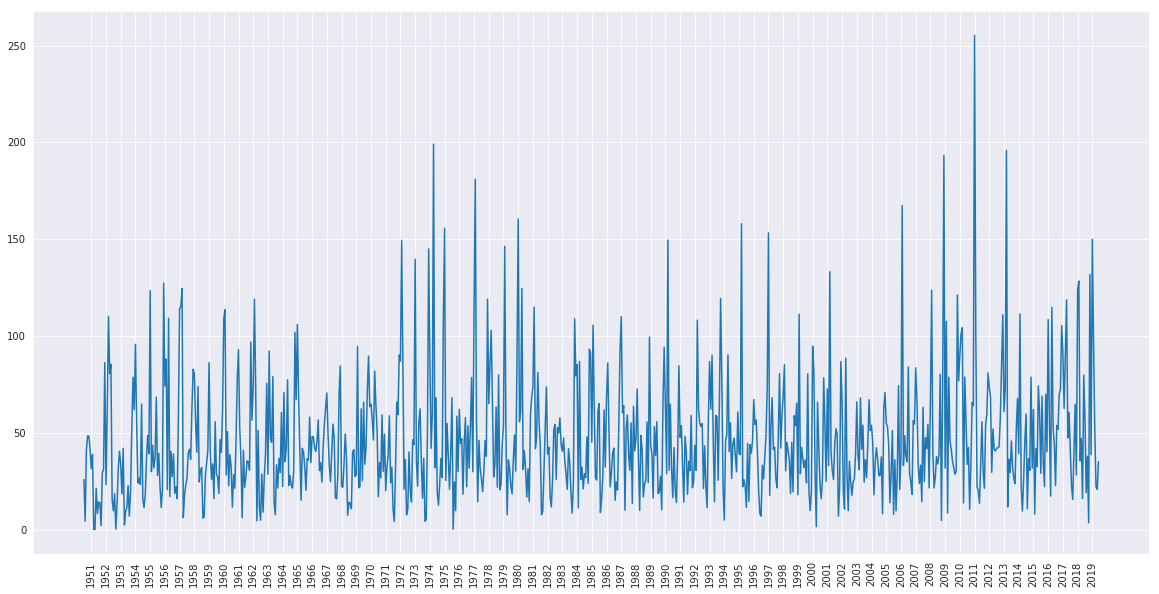

In [4]:
plt.figure(figsize=(20,10))
x_labels_index = data.iloc[6::12].index
x_label = data.iloc[6::12]['year']
plt.xticks(x_labels_index, x_label, rotation=90) 
ax_lineplot = sns.lineplot(data=data['total_precip'])
plt.show()

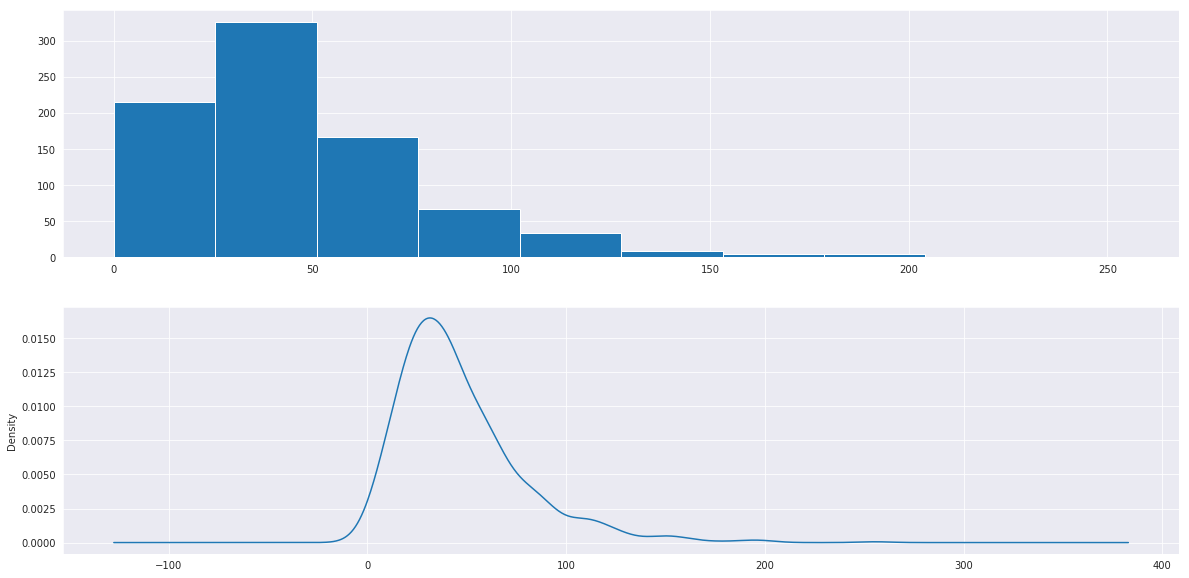

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(211)
data['total_precip'].hist()
plt.subplot(212)
data['total_precip'].plot(kind='density')
plt.show()

# Spliting data into training data and testing data

In [6]:
def prepare_data_for_arima(dataset, training_size=0.8):
    dataset_len = len(dataset)
    limit = int(training_size * dataset_len)
    training = dataset[:limit]
    testing = dataset[limit:]
    return training, testing

In [7]:
data_precip = data.total_precip

In [8]:
train_data_precip, test_data_precip = prepare_data_for_arima(data_precip, training_size=0.8)


# Model Validation Metric




In [9]:
#Mean Absolute Percentage Error
def MAPE(y_true, predictions):
    diff = predictions - y_true
    MAPE = np.mean(np.abs(diff)/np.abs(y_true))
    return MAPE

# Naive prediction


In [10]:
def naive_prediction(train_dataset, test_dataset, lag):
    predictions = []
    observations = []
    for i in range(len(test_dataset)):
        #what is a current observation
        current_observation = test_dataset.iloc[i]         
        observations.append(current_observation)
       #what is a prediction based on "lag"
        prediction_index = i - lag
        if prediction_index<0:
            predictions.append(train_dataset.iloc[prediction_index])
        else:
            predictions.append(test_dataset.iloc[prediction_index])
    return predictions

In [11]:
# evaluating naive prediction for lag value equal to 12
naive_pred_12 = naive_prediction(train_data_precip, test_data_precip,12)
print(MAPE(test_data_precip, naive_pred_12))

0.9053388679441238


In [12]:
# MAPE errors depending on lag value
def evaluate_naive_prediction():
    errors_depending_on_lag = []
    for i in range(121):
        predictions = naive_prediction(train_data_precip, test_data_precip,i)
        errors_depending_on_lag.append((i, MAPE(test_data_precip, predictions), mean_squared_error(test_data_precip, predictions)))
        errors_depending_on_lag.sort(key=lambda x: x[1])
#       # convert to data frame
        df_errors_depending_on_lag= pd.DataFrame(errors_depending_on_lag, columns =['lag [years]', 'MAPE', 'MSE'])
    return df_errors_depending_on_lag

In [61]:
evaluate_naive_prediction()

,lag [years],MAPE,MSE
0,0,0.000000,0.000000
1,84,0.733990,1881.882530
2,120,0.767704,1955.963855
3,60,0.777192,2177.769518
4,97,0.778013,2170.832289
5,115,0.784388,2604.946506
6,36,0.788602,2181.864880
7,48,0.791611,2061.323072
8,117,0.803444,2243.215723
9,34,0.812640,2124.688735


Conclusion: The most favorable error values where obtain for lag parameter of 84 months (7 years). This could mean that in the case of naive prediction the best possible strategy in a given dataset is to use data from the same month month seven years before.

# Using ARIMA model to predict precipitation value.

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

## Testing stationarity of a time series.

In [15]:
fuller_test = adfuller(train_data_precip)
print('ADF:', fuller_test[0])
print('p-value:', fuller_test[1])
print('critical_values:', fuller_test[4])

ADF: -6.906744892943194
p-value: 1.241659286540387e-09
critical_values: {'1%': -3.4405768522418607, '5%': -2.8660524488494903, '10%': -2.569173076930542}


Conclusion: Time series is stationary.

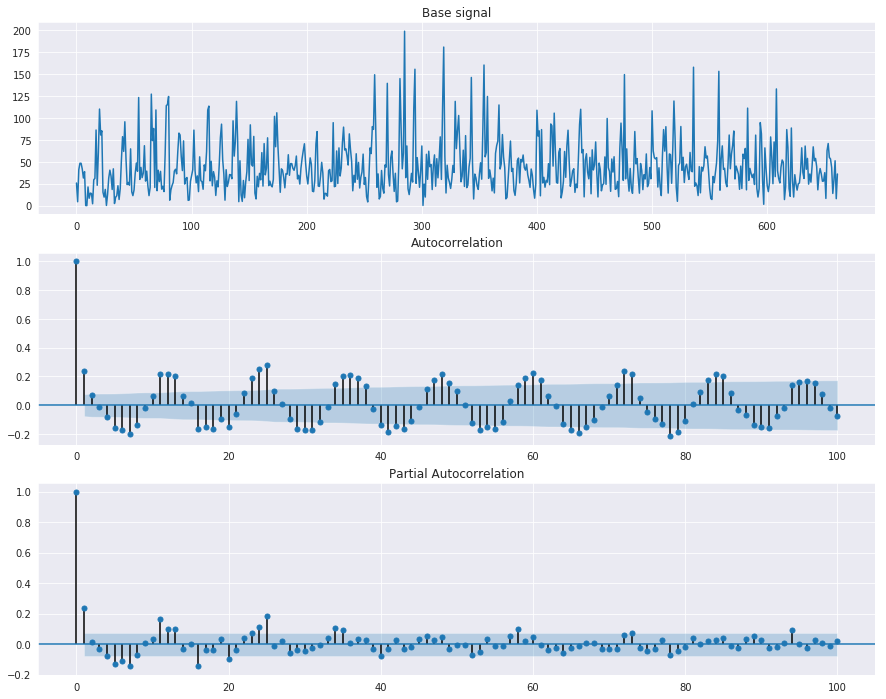

In [16]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15, 12))
axes[0].plot(train_data_precip.values)
axes[0].set_title('Base signal')
plot_acf(train_data_precip.values, ax = axes[1], lags=100)
plot_pacf(train_data_precip.values, ax = axes[2], lags=100)
plt.show()

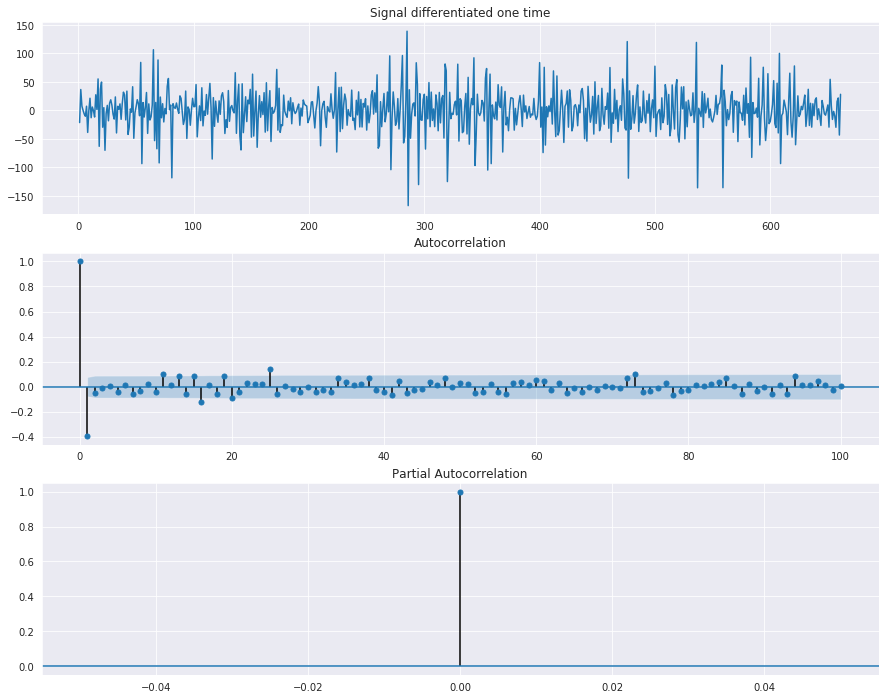

In [17]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15, 12))
axes[0].plot(train_data_precip.diff().values)
axes[0].set_title('Signal differentiated one time')
plot_acf(train_data_precip.diff().dropna().values, ax = axes[1],lags=100)
plot_pacf(train_data_precip.diff().values, ax = axes[2], lags=100)
plt.show()

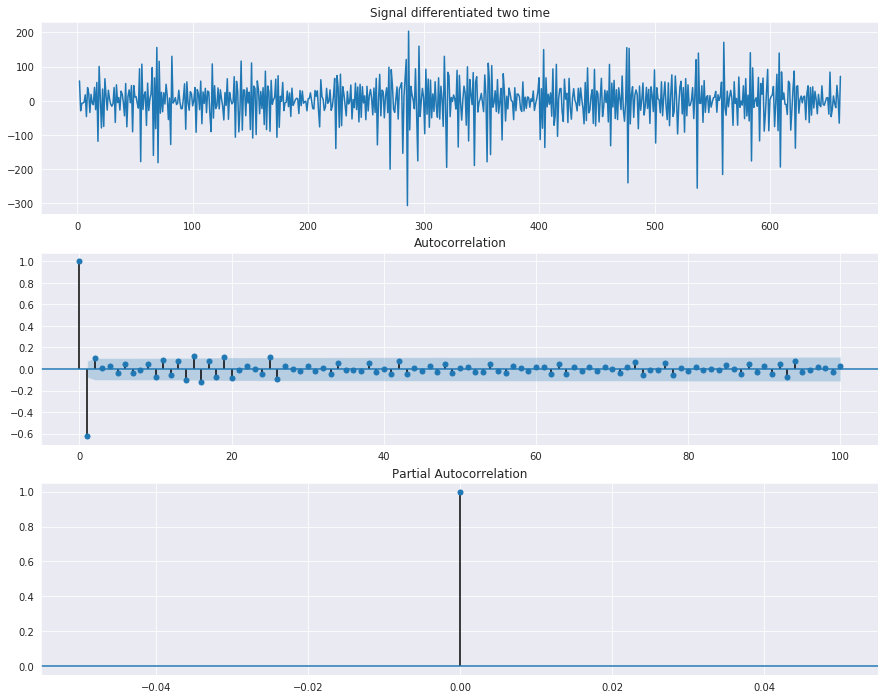

In [18]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15, 12))
axes[0].plot(train_data_precip.diff().diff().values)
axes[0].set_title('Signal differentiated two time')
plot_acf(train_data_precip.diff().diff().dropna().values, ax = axes[1], lags=100)
plot_pacf(train_data_precip.diff().values, ax = axes[2], lags=100)
plt.show()

### Analysing autocorelation and partial autocorelastion for "base signal" and knowing that the time series is stationary I decide to set parameter d=0, p=1 and q=0. 


In [19]:
model = ARIMA(train_data_precip.values, order=(1,0,0))
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  662
Model:                     ARMA(1, 0)   Log Likelihood               -3280.203
Method:                       css-mle   S.D. of innovations             34.308
Date:                Thu, 12 Mar 2020   AIC                           6564.406
Time:                        09:31:16   BIC                           6573.396
Sample:                             0   HQIC                          6567.890
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.7662      0.025     30.796      0.000       0.717       0.815
                                    Roots                                    
                  Real          Imaginary           M

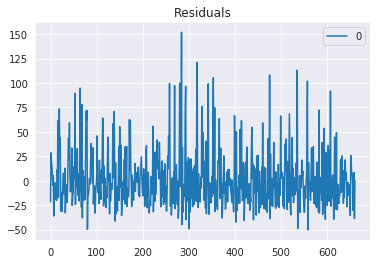

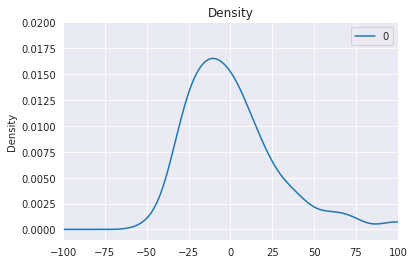

In [40]:
# Residuals analysis
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals')
residuals.plot(kind='kde', title='Density')
plt.axis([-100, 100, -0.001, 0.02])
plt.show()

### Sprawdzenie wykresu dopasowania modelu do danych

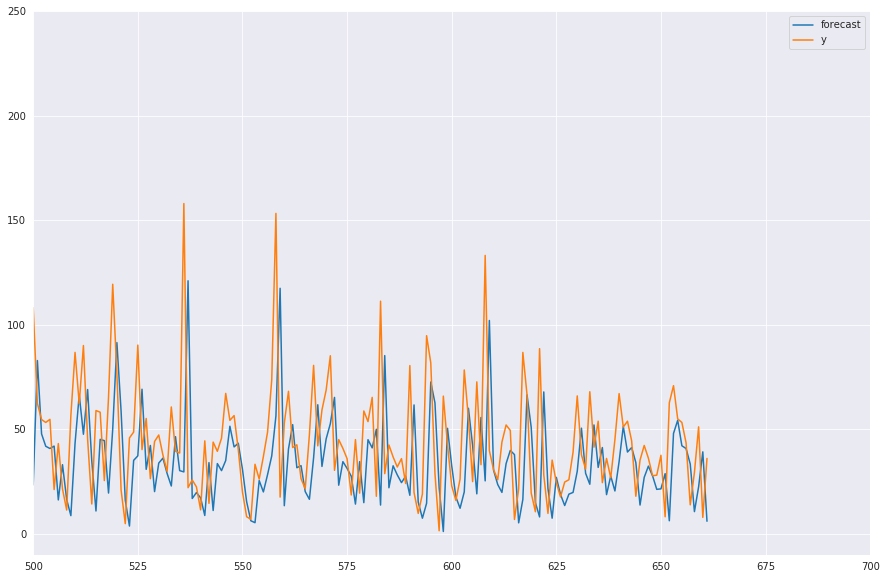

In [22]:
# fig, ax = plt.subplot(1, 1, figsize=(15, 7))
fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.axis([500, 700, -10, 250])
model_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

### Model evaluation

In [23]:
# evaluate an ARIMA model for a given order (p,d,q)
def predict_with_arima_model(train_dataset, test_dataset, arima_order):
    history = [x for x in train_dataset]
    # make predictions
    predictions = list()
    for t in range(len(test_dataset)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        one_step_prediction = model_fit.forecast()[0]
        predictions.extend(one_step_prediction)
        history.append(test_dataset.iloc[t])# calculate out of sample error
    return predictions

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(y_true, predictions):
    MSE_err = mean_squared_error(y_true, predictions)
    MAPE_err = MAPE(y_true, predictions)
    return MSE_err, MAPE_err

In [24]:
# evaluation of trained ARIMA MODEL
order=(1,0,0)
predictions = predict_with_arima_model(train_data_precip, test_data_precip, order)
evaluate_arima_model(test_data_precip, predictions)

(1524.176926304195, 0.7898649391844134)

### How model fit into training data?
Figure of predictions made on training data and the real values.

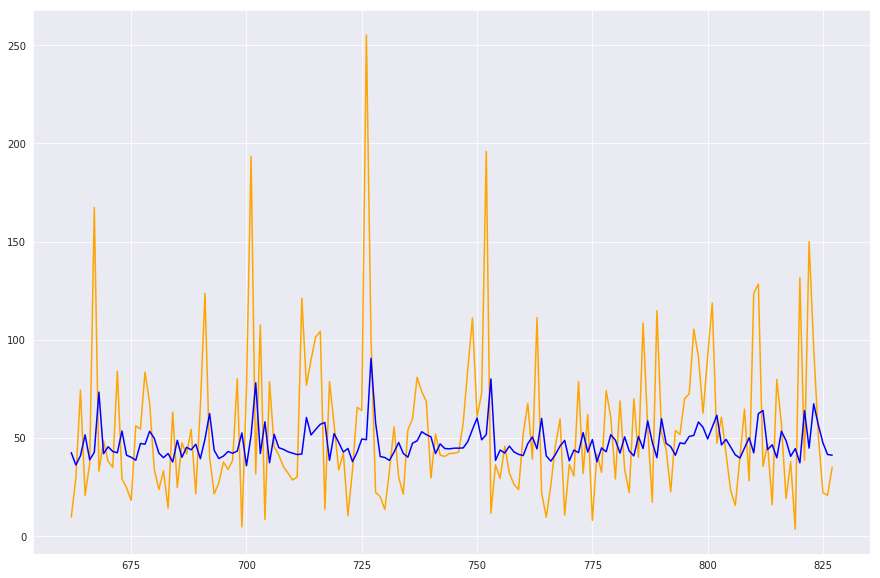

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
# plt.axis([500, 700, -10, 250])
plt.plot(test_data_precip.index, test_data_precip, c='orange')
plt.plot(test_data_precip.index, predictions, c='blue')
plt.show()

# Tuning the model


In [58]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train_data, test_data, p_values, d_values, q_values):
#     train_data = train_data.astype('float32')
#     test_data = test_data.astype('float32')
#     best_score, best_cfg = 4000, None
    scores = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(f'try evaluate order: {order}')
                try:
                    predictions = predict_with_arima_model(train_data, test_data, order)
                    errors = evaluate_arima_model(test_data, predictions)
#                     if errors[0] < best_score:
#                         best_score = errors[0]
#                         best_cfg = order
                    scores.append([order, errors])
                    print(f'ARIMA MSE:{errors[0]}, MAPE {errors[1]}: , hyperparameters: {order}')
                except:
                    print(f'error occured for order: {order}')
                    continue
    print(f'scores: {scores}')

In [60]:
# evaluate parameters
p_values = [0, 12]
d_values = range(0, 2) #should be 0 as the Time Series is stationary
q_values = range(0,2)
evaluate_models(train_data_precip, test_data_precip, p_values, d_values, q_values)

try evaluate order: (0, 0, 0)
ARIMA MSE:1537.6546770809068, MAPE 0.7471232986685318: , hyperparameters: (0, 0, 0)
try evaluate order: (0, 0, 1)
ARIMA MSE:1530.3820330087906, MAPE 0.7875923003173241: , hyperparameters: (0, 0, 1)
try evaluate order: (0, 1, 0)
ARIMA MSE:2660.3968574550167, MAPE 1.1144906965526682: , hyperparameters: (0, 1, 0)
try evaluate order: (0, 1, 1)
ARIMA MSE:1499.317053184521, MAPE 0.8178873504477163: , hyperparameters: (0, 1, 1)
try evaluate order: (12, 0, 0)
ARIMA MSE:1367.8176316159136, MAPE 0.7409650044098334: , hyperparameters: (12, 0, 0)
try evaluate order: (12, 0, 1)
ARIMA MSE:1354.096404966058, MAPE 0.7461410090300415: , hyperparameters: (12, 0, 1)
try evaluate order: (12, 1, 0)
ARIMA MSE:1383.9872248906754, MAPE 0.8629851666965997: , hyperparameters: (12, 1, 0)
try evaluate order: (12, 1, 1)
ARIMA MSE:1370.0243721628453, MAPE 0.8593503678963939: , hyperparameters: (12, 1, 1)
scores: [[(0, 0, 0), (1537.6546770809068, 0.7471232986685318)], [(0, 0, 1), (1530.

In [62]:
# evaluate a mode for p=24 as autocorelation Figure shows, that this value also could give a good resul.
p_values = [24]
d_values = [0] #should be 0 as the Time Series is stationary
q_values = [1]
evaluate_models(train_data_precip, test_data_precip, p_values, d_values, q_values)

try evaluate order: (24, 0, 1)
error occured for order: (24, 0, 1)
scores: []


#### Testing the model with p=24 faild beacuse of a very long time of training.

### Training the model again for with the best parameters p=12, d=0, q=1 chosen by evaluating the model with Mean Squared Error metric.

In [66]:
best_order=(12,0,1)
best_model = ARIMA(train_data_precip.values, order=best_order)
best_model_fit = best_model.fit(trend='nc')
print(best_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  662
Model:                    ARMA(12, 1)   Log Likelihood               -3143.527
Method:                       css-mle   S.D. of innovations             27.849
Date:                Thu, 12 Mar 2020   AIC                           6315.053
Time:                        16:34:25   BIC                           6377.987
Sample:                             0   HQIC                          6339.443
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.7850      0.156      5.038      0.000       0.480       1.090
ar.L2.y       -0.0791      0.062     -1.276      0.202      -0.201       0.042
ar.L3.y        0.0128      0.050      0.253      0.8

In [67]:
predictions = predict_with_arima_model(train_data_precip, test_data_precip, best_order)
evaluate_arima_model(test_data_precip, predictions)

(1354.096404966058, 0.7461410090300415)

### How model fit into training data?
Figure of predictions made on training data and the real values.

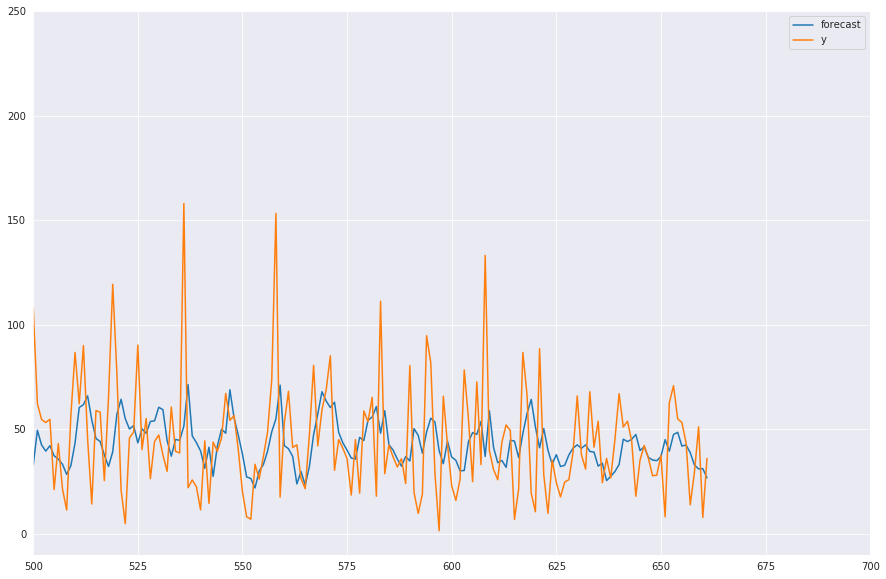

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.axis([500, 700, -10, 250])
best_model_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

# Graphic model evaluation against testing dataset
Figure of model predictions compared to real testing dataset.

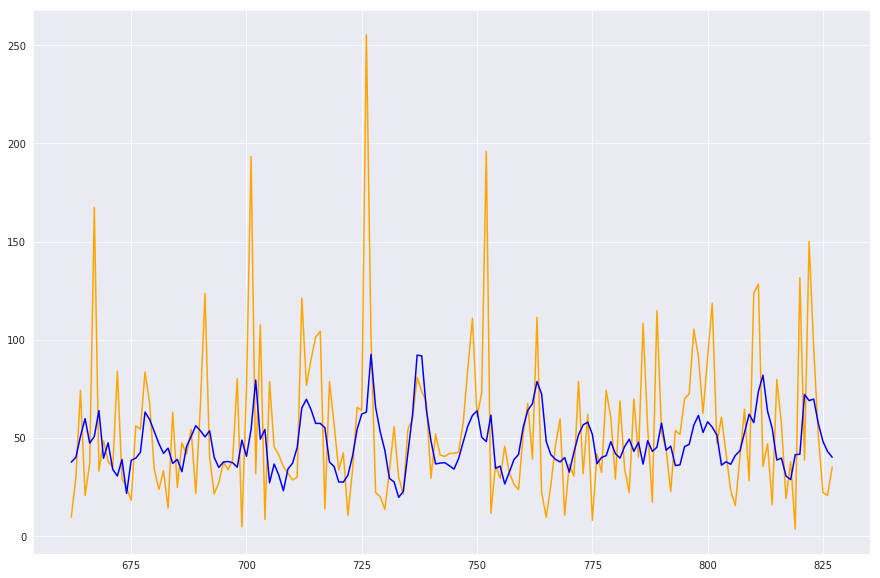

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
# plt.axis([500, 700, -10, 250])
plt.plot(test_data_precip.index, test_data_precip, c='orange')
plt.plot(test_data_precip.index, predictions, c='blue')
plt.show()

# Saving a trained model 

As traing and tuning model took a relatively long time, the best model version will be saved to a file.

In [70]:
from statsmodels.tsa.arima_model import ARIMAResults
best_model_fit.save('model.pkl')

To load model from a file use:
```python
# load model
# loaded = ARIMAResults.load('model.pkl')```

# Conclusions:
- The precipitation data for town WIZNA has a sesonality but no evident trend over 69 years.
- The precipitation data for town WIZNA are the stationary time series.
- Naive prediction for this time series can be done with:
    * For a lag value equal to 12 (prediction based on a valu occured 1 year ago):
        * Mean Squared Error at the level of 2143.465542
        * Mean Absolute Percentage Error 0.905339
    * For a lag value equal to 84 (prediction based on a valu occured 7 year ago):
        * Mean Squared Error at the level of 1881.882530
        * Mean Absolute Percentage Error	0.733990 	
- This phenomenon can be modeled using ARIMA model
- Testing differend p, d, q values for ARIMA model showed that the best hyperparameters are:
    * p = 12
    * d = 0
    * q = 1
- The best from tested models have following error values:
    * Mean Squared Error at the level of 1354.096404966058, 
    * Mean Absolute Percentage Error 0.7461410090300415
- The ARIMA model result is slightly better than naive prediction.
- Further investigation should be focused on evaluating models such as SARIMA, which is designed for modeling data with sesonality.